In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords

## we are most likely going to have to use fuzzy wuzzy to match car models 

In [2]:
reviews = pd.read_csv('cust_review.csv')
reviews.head()

,Company,Model,Year,Reviewer,Date,Title,Rating
0,acura,ilx,2013,mahowald,08/12/2012,Getting 43 Mpg on daily commute,5
1,acura,ilx,2013,VIP,07/26/2016,New to me ILX,5
2,acura,ilx,2013,bybchucky,09/14/2013,Excellet Commuter Car,4
3,acura,ilx,2013,bayareamom,01/26/2015,Peppy Hybrid that Turns Heads,4
4,acura,ilx,2013,Kerry Olson,03/26/2016,2013 Acura ILX Hybrid w/ Tech Package,5


In [3]:
## see if there are any makes with too few reviews 

reviews['Company'].value_counts(ascending=True).head(10)

rolls-royce      41
aston-martin     99
plymouth        100
lotus           146
ferrari         165
bentley         168
alfa-romeo      221
maserati        318
tesla           453
fiat            553
Name: Company, dtype: int64

In [4]:
stocks = pd.read_csv('autostocks_2010_2022.csv')
stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2009-12-31,TM,71.532616,84.160004,85.160004,84.160004,85.160004,223400.0
1,2009-12-31,F,6.710280,10.000000,10.060000,9.920000,10.040000,31253700.0
2,2009-12-31,HMC,33.738770,33.900002,34.040001,33.840000,33.840000,567400.0
3,2009-12-31,HYMTF,17.000000,17.000000,17.000000,17.000000,17.000000,0.0
4,2009-12-31,TTM,15.805059,16.860001,17.080000,16.830000,16.940001,586100.0


In [5]:
## so my 3 starting files: reviews, stocks, maker_list

## market cap is interesting but since it is a snapshot of the value it will not really help

maker_list = pd.read_csv('maker_namelist.csv')
maker_list.head()

,Rank,Name,Symbol,marketcap,price (USD),country
0,1,Tesla,TSLA,9.112050e+11,907.34,United States
1,2,Toyota,TM,2.742580e+11,197.24,Japan
2,3,Volkswagen,VOW3.DE,1.243960e+11,201.18,Germany
3,4,BYD,002594.SZ,1.077790e+11,37.02,China
4,5,Daimler,DAI.DE,8.582425e+10,80.22,Germany


In [6]:
## names in maker_list are in Proper so make them lowercase

maker_list['Name'] = maker_list['Name'].str.lower()


In [7]:
maker_list['Name'].head(3)

0         tesla
1        toyota
2    volkswagen
Name: Name, dtype: object

In [8]:
## make a dataframe of unique makes in both lists
## see obvious differences by sorting (aston martin, volvo) 

ml_unique = list(maker_list['Name'].unique())
rv_unique = list(reviews['Company'].unique())
all_makes = pd.DataFrame(ml_unique+rv_unique,columns=['name'])
makes = list(all_makes['name'].unique())
sorted(makes)

['acura',
 'alfa-romeo',
 'arcimoto',
 'arrival',
 'aston martin',
 'aston-martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'byd',
 'cadillac',
 'canoo',
 'cenntro electric group',
 'chevrolet',
 'chongqing changan',
 'chrysler',
 'daimler',
 'dodge',
 'dongfeng motor',
 'electra meccanica',
 'faw car',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'geely',
 'general motors',
 'gmc',
 'great wall motors',
 'honda',
 'hotai motor',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'land-rover',
 'lexus',
 'li auto',
 'lincoln',
 'lordstown motors',
 'lotus',
 'lucid motors',
 'mahindra &amp; mahindra',
 'maruti suzuki india',
 'maserati',
 'mazda',
 'mercedes-benz',
 'mercury',
 'mini',
 'mitsubishi',
 'nikola',
 'nio',
 'nissan',
 'oldsmobile',
 'plymouth',
 'polaris',
 'pontiac',
 'porsche',
 'ram',
 'ree automotive',
 'renault',
 'rivian',
 'rolls-royce',
 'saab',
 'saic motor',
 'sono',
 'ssangyong motor',
 'stellantis',
 'subaru',
 'suzuki',
 'suzuki motor',
 'tata motors

In [9]:
## change volvo and aston martin so they match in the two lists
## we can change the name of car makers in maker_list because
## we will be joining with stocks  using stock symbol 
## row for volvo car is 22 and for aston martin is 39  -- column name is Name

maker_list.loc[22,'Name'] = 'volvo'
maker_list.loc[39,'Name'] = 'aston-martin'

In [10]:
fixed_makes = ['volvo','aston-martin']
maker_list.loc[maker_list['Name'].isin(fixed_makes)]

,Rank,Name,Symbol,marketcap,price (USD),country
22,23,volvo,VOLCAR-B.ST,2.211759e+10,7.42,Sweden
39,40,aston-martin,A5SA.F,1.780768e+09,15.28,United Kingdom


In [11]:
## The maker list contains brands that contain within them other brands
## like general motors: chevrolet, cadillac, etc. and volkswagen contains audi, porche
## I could add a new column to reviews data to link, but I think it will be best to add those brands + stockid
## to the much shorter makers list 
## stellantis has just recently bought dodge and chrysler, so I will not be be pairing them
## I will only be pairing makers with parent companies that have been together for a long time

#toyota - lexus ___ volkswagen - audi, ___ general motors - chevrolet, cadillac, buick, gmc, pontiac _ 
#ford - lincoln, ___ honda - acura ___ daimler, mercedes-benz __

maker_list.columns

Index(['Rank', 'Name', 'Symbol', 'marketcap', 'price (USD)', 'country'], dtype='object')

In [12]:
## we can do a simple name change for daimler bc parent company is not a make
maker_list.loc[4,'Name'] = 'mercedes-benz'

In [13]:
## create a dictionary with the new entries for makes 

## but first we are going to drop all columns that we wont be using
## we only need this maker list to link to stocks so only keep : ['Name'],['Symbol']

maker_list.drop(columns = ['Rank', 'marketcap', 'price (USD)', 'country'], inplace=True)

maker_list.columns

Index(['Name', 'Symbol'], dtype='object')

In [14]:
#Using this symbols we are going to make the new rows and concat to maker_list

parents = ['toyota', 'volkswagen', 'general motors','ford', 'honda']
maker_list.loc[maker_list['Name'].isin(parents)]

,Name,Symbol
1,toyota,TM
2,volkswagen,VOW3.DE
5,general motors,GM
6,ford,F
9,honda,HMC


In [15]:
car_dict = {'Name':['lexus','audi', 'chevrolet', 'cadillac', 'buick', 'gmc', 'pontiac', 'lincoln', 'acura'],
        'Symbol':['TM', 'VOW3.DE', 'GM', 'GM','GM','GM','GM','F','HMC']
       }
makes_to_add = pd.DataFrame(car_dict)
make_x_symbol = pd.concat([maker_list, makes_to_add], ignore_index = True)
make_x_symbol.reset_index()
parents_kids = ['toyota', 'volkswagen', 'general motors','ford', 'honda','lexus','audi', 'chevrolet', 'cadillac', 'buick', 'gmc', 'pontiac', 'lincoln', 'acura']
make_x_symbol.loc[make_x_symbol['Name'].isin(parents_kids)]

,Name,Symbol
1,toyota,TM
2,volkswagen,VOW3.DE
5,general motors,GM
6,ford,F
9,honda,HMC
48,lexus,TM
49,audi,VOW3.DE
50,chevrolet,GM
51,cadillac,GM
52,buick,GM


In [16]:
## we create unique lists again, but wuth the two above now matching 
ms_unique = list(make_x_symbol['Name'].unique())
rv_unique = list(reviews['Company'].unique())
all_makes2 = pd.DataFrame(ms_unique+rv_unique,columns=['name'])
makes2 = list(all_makes2['name'].unique())
len(makes2)

78

In [17]:
## see which makes appear in both lists after changes above

isin_both2 = []
for x in makes2:
    if ((x in ms_unique) and (x in rv_unique)):
        isin_both2.append(x)
isin_both2

['tesla',
 'toyota',
 'volkswagen',
 'mercedes-benz',
 'ford',
 'bmw',
 'honda',
 'ferrari',
 'hyundai',
 'kia',
 'volvo',
 'nissan',
 'subaru',
 'isuzu',
 'mazda',
 'aston-martin',
 'lexus',
 'audi',
 'chevrolet',
 'cadillac',
 'buick',
 'gmc',
 'pontiac',
 'lincoln',
 'acura']

In [18]:
## so now we have a revised list of makes: ** make_x_symbol ** 
## time to explore review
## models may not be helpful with so may different ones 
## It would interesting to see the variance within makes, which make is more consistent in ratings?

reviews['Model'].value_counts()

accord                           3650
cr-v                             3500
civic                            3257
camry                            3057
focus                            2806
                                 ... 
escape-plug-in-hybrid               1
continental-flying-spur-speed       1
m3-cs                               1
fusion-plug-in-hybrid               1
mulsanne                            1
Name: Model, Length: 897, dtype: int64

In [19]:
missing = pd.DataFrame({'count_na':reviews.isna().sum(),'%na':100*reviews.isna().sum()/len(reviews['Company'])})
missing

,count_na,%na
Company,0,0.000000
Model,0,0.000000
Year,0,0.000000
Reviewer,100,0.033440
Date,17,0.005685
Title,22,0.007357
Rating,0,0.000000


In [20]:
# missing dates, only 12(with makes we will use) out of 300thousand 
# we could possibly just delete them 

missing_date = reviews[reviews['Date'].isna()]
missing_date

,Company,Model,Year,Reviewer,Date,Title,Rating
24711,bmw,6-series,2006,Elle R,NaN,The most amazing car to drive,4
40850,chevrolet,equinox,2010,Don G,NaN,Guarantee you'll love this car!,4
47090,chevrolet,silverado-1500,2009,Patrick,NaN,Find to be the best truck in quality dependabl...,5
49358,chevrolet,suburban,2009,AnthonyinCastleRock,NaN,SofarSogood,4
51186,chevrolet,trailblazer,2004,Chad R,NaN,Done with GM,3
57448,chevrolet,malibu-maxx,2004,Toyota&Honda Owner,NaN,More than a Econobox,5
73178,dodge,caravan,2006,Ted D,NaN,First Time Mini Owner,4
83238,ford,escape,2016,J,NaN,Rescued From VW Scandal....,4
112787,honda,civic,2005,andrew b,NaN,2005 civic si review,4
123074,honda,odyssey,2019,Doug H,NaN,Wonderful Minivan,5


In [21]:
#drop na's
reviews.dropna(subset=['Date'], inplace = True)

check_missing = pd.DataFrame({'count_na':reviews.isna().sum(),'%na':100*reviews.isna().sum()/len(reviews['Company'])})
check_missing

,count_na,%na
Company,0,0.000000
Model,0,0.000000
Year,0,0.000000
Reviewer,100,0.033442
Date,0,0.000000
Title,22,0.007357
Rating,0,0.000000


In [22]:
# my reviews are heavily squewed towards 5's
reviews['Rating'].describe()

count    299028.000000
mean          3.980885
std           0.993002
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

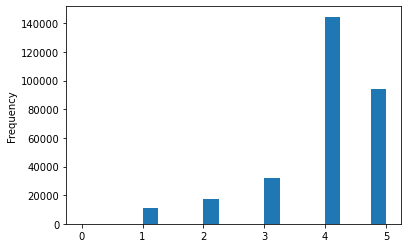

In [23]:
# have to do histogram
# now we can visualize how skewed to the right the ratings are 

reviews['Rating'].plot(kind='hist',bins=20)
plt.show()

In [24]:
# out of curiosity, repeat reviews from reviewers
# most are men, and I doubt they are unique usernames 
# no important information in this column probable will delete as well 
reviews['Reviewer'].value_counts().head(15)

Mike     1167
John     1050
Dave      748
Steve     696
Jim       684
Chris     671
Bill      611
Mark      606
Bob       585
David     570
Tom       561
Dan       509
Joe       504
Jeff      463
Paul      439
Name: Reviewer, dtype: int64

In [25]:
#not all comments are string 
reviews['Title'].dtypes

dtype('O')

In [26]:
#not all reviews are strings

reviews['Title'] = reviews['Title'].astype(str)

In [27]:
#make_x_symbol.loc[make_x_symbol['Name'].isin(parents_kids)]
#seeing if there is any good data in reviews['Title']
# ALOT of the reviews are overwhelmingly positive, or at least it seems so from word density 

p = Counter(" ".join(reviews['Title'].str.lower()).split()).most_common(30)
rslt = pd.DataFrame(p, columns=['Word', 'Frequency'])
no_use = ['the','a','i','to','my','and','of','for','my','with','is','this','it','in','-','not','car','so','very','but']
rslt.loc[~rslt['Word'].isin(no_use)]

,Word,Frequency
1,great,31034
5,love,20041
7,best,15062
11,good,10545
17,fun,8216
19,suv,7570
23,truck,5868
24,vehicle,5844
25,ever,5823
26,buy,5797


In [28]:
reviews.drop(columns=['Title','Reviewer'], inplace=True)
reviews.columns

Index(['Company', 'Model', 'Year', 'Date', 'Rating'], dtype='object')

In [29]:
#Year referes to *model Year* and there are NO MISSING values 
#older model cars seem to get more reviews than newer ones 
#no years out of range 2000-2022 

reviews['Year'].describe()

count    299028.000000
mean       2007.492124
std           5.330818
min        2000.000000
25%        2003.000000
50%        2006.000000
75%        2011.000000
max        2020.000000
Name: Year, dtype: float64

In [30]:
#do we have enough stock info for all makes?
#have to watch out for volvo 

stocks['Symbol'].value_counts().sort_values(ascending = True)[0:10]

SEV             56
RIVN            61
VOLCAR-B.ST     69
REE            270
LCID           350
XPEV           365
LI             385
ARVL           509
RIDE           708
GOEV           710
Name: Symbol, dtype: int64

In [31]:
# now we can take a look at stocks 

stocks.describe()

,Adj Close,Close,High,Low,Open,Volume
count,101126.000000,101126.000000,101126.000000,101126.000000,101126.000000,1.011260e+05
mean,2159.335449,2410.854244,2447.217844,2373.561183,2412.369142,1.191571e+07
std,8620.102966,9753.135871,9891.838774,9607.236311,9759.656137,2.533131e+07
min,0.910000,0.910000,0.990000,0.890000,0.930000,0.000000e+00
25%,12.698408,15.260000,15.560000,15.000000,15.290000,5.501000e+05
50%,49.361683,55.560001,56.375000,54.800999,55.594999,2.612150e+06
75%,581.039612,644.000000,653.000000,635.000000,644.000000,1.260817e+07
max,97896.445312,101500.000000,102000.000000,96300.000000,100500.000000,9.511580e+08


In [32]:
# no missing values

stocks.isna().sum()

Date         0
Symbol       0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [90]:
stocks.dtypes

Date          object
Symbol        object
Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
dtype: object

In [91]:
#since all float columns appear about the same (except for volume which measures something different)
#i am going to just pick one column to study and drop the others

date_symbol_open = stocks.drop(columns = ['Adj Close','Close','High','Low','Volume'])
date_symbol_open.head()

,Date,Symbol,Open
0,2009-12-31,TM,85.160004
1,2009-12-31,F,10.040000
2,2009-12-31,HMC,33.840000
3,2009-12-31,HYMTF,17.000000
4,2009-12-31,TTM,16.940001


In [33]:
make_x_symbol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    57 non-null     object
 1   Symbol  57 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB


In [34]:
reviews.columns

Index(['Company', 'Model', 'Year', 'Date', 'Rating'], dtype='object')

In [35]:
## I think I should link make_x_symbol with *reviews* so that every review has a symbol
## Rename make columns so that they have same name 'Company' 

make_x_symbol.rename(columns = {'Name':'Company'}, inplace = True)
make_x_symbol.columns

Index(['Company', 'Symbol'], dtype='object')

In [36]:
## see https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_sql.html
## left outer join = left join ---  you cant SELECT specific columns it seems 

In [38]:
review_x_symbol = pd.merge(reviews, make_x_symbol, on="Company", how="left")
review_x_symbol.head(10)

,Company,Model,Year,Date,Rating,Symbol
0,acura,ilx,2013,08/12/2012,5,HMC
1,acura,ilx,2013,07/26/2016,5,HMC
2,acura,ilx,2013,09/14/2013,4,HMC
3,acura,ilx,2013,01/26/2015,4,HMC
4,acura,ilx,2013,03/26/2016,5,HMC
5,acura,ilx,2013,06/19/2012,4,HMC
6,acura,ilx,2013,01/29/2013,5,HMC
7,acura,ilx,2013,05/19/2019,5,HMC
8,acura,ilx,2013,10/25/2016,5,HMC
9,acura,ilx,2013,07/27/2012,4,HMC


In [41]:
## drop columns after ['rating2022']
## drop rows after 56

expert_reviews = pd.read_csv('expert_reviews.csv', header = 1)
expert_reviews.tail(19)

,make,model,rating2007,rating2008,rating2009,rating2010,rating2011,rating2012,rating2013,rating2014,...,rating2018,rating2019,rating2020,rating2021,rating2022,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
52,lexus,IS,NaN,NaN,NaN,8.3,8.5,8.2,8.1,8.0,...,8.1,7.5,7.5,7.3,7.4,NaN,NaN,NaN,NaN,NaN
53,lexus,ES,NaN,NaN,NaN,9.2,9.1,8.8,8.3,8.6,...,8.5,8.1,7.9,8.3,8.2,NaN,NaN,NaN,NaN,NaN
54,mercedes.benz,c.class,NaN,NaN,NaN,NaN,NaN,7.9,7.8,8.2,...,7.8,7.9,8.0,8.4,NaN,NaN,NaN,NaN,NaN,NaN
55,mercedes.benz,e.class,NaN,NaN,NaN,9,8.8,9.1,8.8,8.4,...,7.6,8.0,7.9,8.7,8.7,NaN,NaN,NaN,NaN,NaN
56,mercedes.benz,GLS,NaN,NaN,NaN,7.5,7.9,7.8,7.4,7.7,...,7.6,8.0,7.1,8.1,8.2,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
expert_reviews.drop(columns = ['Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22'],inplace = True)
expert_reviews.columns

Index(['make ', 'model', 'rating2007', 'rating2008', 'rating2009',
       'rating2010', 'rating2011', 'rating2012', 'rating2013', 'rating2014',
       'rating2015', 'rating2016', 'rating2017', 'rating2018', 'rating2019',
       'rating2020', 'rating2021', 'rating2022'],
      dtype='object')

In [42]:
rows_to_drop = []
for x in range(57,71):
    rows_to_drop.append(x)
rows_to_drop

[57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

In [45]:
expert_reviews.drop(rows_to_drop, inplace = True)
expert_reviews.tail(18)

,make,model,rating2007,rating2008,rating2009,rating2010,rating2011,rating2012,rating2013,rating2014,rating2015,rating2016,rating2017,rating2018,rating2019,rating2020,rating2021,rating2022
39,Buick,Enclave,NaN,8.6,8.3,8.3,8.6,8.6,9.0,8.5,8.5,8.4,8.2,8.0,7.9,8.0,8,8.3
40,Buick,Regal,NaN,NaN,NaN,NaN,8.1,8.0,8.4,8.0,8.2,8.1,7.5,8.0,8.0,7.6,NaN,NaN
41,Buick,LaCrosse,7.5,7.5,7.8,8.4,9.2,8.2,8.6,9.0,8.9,9.0,8.6,8.8,8.1,NaN,NaN,NaN
42,Cadillac,Escalade,9.1,9.3,9,8.3,9.1,8.6,8.0,8.0,8.2,7.6,7.1,7.2,6.9,6.7,8.3,8.5
43,Cadillac,ATS,NaN,NaN,NaN,NaN,NaN,NaN,7.3,7.3,7.8,7.5,7.9,7.4,7.1,NaN,NaN,NaN
44,Cadillac,CTS,8.0,9,8.7,8.8,8.8,8.2,8.4,8.4,8.6,8.2,7.9,7.7,7.6,NaN,NaN,NaN
45,audi,Q5,NaN,NaN,NaN,8.5,8.0,8.0,8.2,7.7,7.6,7.6,7.7,8.0,8.5,8.0,8.2,8.2
46,audi,A4,NaN,NaN,NaN,8,7.9,8.5,8.8,8.0,8.5,8.3,8.3,8.4,8.5,8.6,NaN,8.6
47,audi,A6,NaN,NaN,NaN,9.1,8.2,7.8,7.8,8.3,8.2,8.2,8.1,8.4,7.8,7.9,8.2,8.2
48,acura,ILX,NaN,NaN,NaN,NaN,NaN,NaN,7.4,7.9,7.1,7.4,7.2,7.3,6.2,7.3,6.8,6.7


In [46]:
## change model names to lowercase, and make sure they match the ones above 
## ['make '] column has a trailing space 

expert_reviews.rename(columns={'make ':'Company','rating2007':2007, 'rating2008':2008, 'rating2009':2009, 'rating2010':2010,
       'rating2011':2011, 'rating2012':2012, 'rating2013':2013, 'rating2014':2014, 'rating2015':2015,
       'rating2016':2016, 'rating2017':2017, 'rating2018':2018, 'rating2019':2019, 'rating2020':2020,
       'rating2021':2021, 'rating2022':2022}, inplace=True)
expert_reviews.columns

Index(['Company',   'model',      2007,      2008,      2009,      2010,
            2011,      2012,      2013,      2014,      2015,      2016,
            2017,      2018,      2019,      2020,      2021,      2022],
      dtype='object')

In [50]:
# create a year column (melt?) make it same format as reviews
# change name of columns to just the number 

company_year_expert = expert_reviews.melt(id_vars=['Company','model'], var_name='Year', value_name = 'Expert_rating').sort_values('Company')
company_year_expert.head(20)

,Company,model,Year,Expert_rating
618,acura,ILX,2017,7.2
791,acura,RDX,2020,8.1
790,acura,MDX,2020,8.2
789,acura,ILX,2020,7.3
675,acura,ILX,2018,7.3
676,acura,MDX,2018,8.2
677,acura,RDX,2018,8.3
390,acura,ILX,2013,7.4
391,acura,MDX,2013,8.5
392,acura,RDX,2013,7.5


In [54]:
## change name of 'mercedes.benz' to 'mercedes-benz'
company_year_expert['Company'].replace(' mercedes.benz', 'mercedes-benz', inplace=True)
company_year_expert['Company'].value_counts()

 acura           48
Hyundai          48
Volkswagen       48
Toyota           48
Tesla            48
Subaru           48
Nissan           48
Mazda            48
Kia              48
Honda            48
 audi            48
Ford             48
Chevrolet        48
Cadillac         48
Buick            48
BMW              48
mercedes-benz    48
 lexus           48
Volvo Car        48
Name: Company, dtype: int64

In [57]:
## make all names in Company lowercase and eliminate trailing spaces
company_year_expert['Company'] = company_year_expert['Company'].str.strip()
company_year_expert['Company'].value_counts()

acura            48
Hyundai          48
Volkswagen       48
Toyota           48
Tesla            48
Subaru           48
Nissan           48
Mazda            48
Kia              48
Honda            48
audi             48
Ford             48
Chevrolet        48
Cadillac         48
Buick            48
BMW              48
mercedes-benz    48
lexus            48
Volvo Car        48
Name: Company, dtype: int64

In [58]:
company_year_expert['Company'] = company_year_expert['Company'].str.lower()
company_year_expert['Company'].value_counts()

acura            48
hyundai          48
volkswagen       48
toyota           48
tesla            48
subaru           48
nissan           48
mazda            48
kia              48
honda            48
audi             48
ford             48
chevrolet        48
cadillac         48
buick            48
bmw              48
mercedes-benz    48
lexus            48
volvo car        48
Name: Company, dtype: int64

In [78]:
#some NAN's are dots instead NaN, switch and then delete NaN's
##also change Expert_rating column to float (must be done after getting rid of dots and NaN's or else error)
#company_year_expert['Expert_rating'] = company_year_expert['Expert_rating'].astype('float')

company_year_expert['Expert_rating'].replace('.', np.nan, inplace=True)
company_year_expert.tail(20)

,Company,model,Year,Expert_rating
721,volvo car,S60,2019,7.7
209,volvo car,XC90,2010,7.4
208,volvo car,S60,2010,NaN
207,volvo car,XC60,2010,7.9
720,volvo car,XC60,2019,7.9
38,volvo car,XC90,2007,7.9
37,volvo car,S60,2007,8.2
36,volvo car,XC60,2007,NaN
494,volvo car,XC90,2015,NaN
378,volvo car,XC60,2013,7.6


In [79]:
company_year_expert.isna().sum()

Company            0
model              0
Year               0
Expert_rating    117
dtype: int64

In [80]:
company_year_expert.dropna(inplace=True)
company_year_expert.isna().sum()

Company          0
model            0
Year             0
Expert_rating    0
dtype: int64

In [83]:
#company_year_expert['Expert_rating'] = company_year_expert['Expert_rating'].astype('float')
company_year_expert.dtypes

Company           object
model             object
Year              object
Expert_rating    float64
dtype: object

In [84]:
#now that the Expert_rating column is float we can actually describe it
#same as customer reviews, expert reviews are heavily skewed 'right' or towards high scores

company_year_expert['Expert_rating'].describe()

count    795.000000
mean       8.187673
std        0.505685
min        6.200000
25%        7.900000
50%        8.200000
75%        8.500000
max        9.600000
Name: Expert_rating, dtype: float64

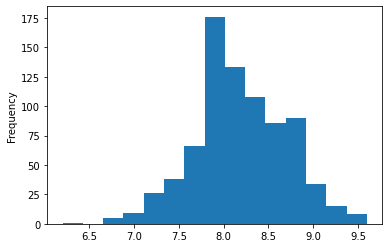

In [88]:
#visualize scores
company_year_expert['Expert_rating'].plot(kind='hist',bins=15)
plt.show()

In [92]:
#so now merge company_year_expert so that they have symbol 

symbol_year_expert = pd.merge(company_year_expert, make_x_symbol, on="Company", how="left")
symbol_year_expert.head()

,Company,model,Year,Expert_rating,Symbol
0,acura,ILX,2017,7.2,HMC
1,acura,RDX,2020,8.1,HMC
2,acura,MDX,2020,8.2,HMC
3,acura,ILX,2020,7.3,HMC
4,acura,ILX,2018,7.3,HMC


In [98]:
#review_x_symbol, date_symbol_open, symbol_year_expert are my three cleaned csv's
#review_x_symbol.to_csv('cleaned_data/review_x_symbol1.csv')
#date_symbol_open.to_csv('cleaned_data/date_symbol_open1.csv')
#symbol_year_expert.to_csv('cleaned_data/symbol_year_expert1.csv')